# Beer Score Data Exploration and Analysis
This notebook transforms data sourced from [https://data.world/socialmediadata/beeradvocate](https://data.world/socialmediadata/beeradvocate) as part of creating a beer prediction machine learning model.  The dataset is ~1.5 million reviews, spanning more than 10 years **(insert date range)**.  Each review includes ratings from [ratebeer](https://www.ratebeer.com/Story.asp?StoryID=103) across five "features": appearance, aroma, palate, taste, and overall impression.  A quick explanation of each rating follows however for a full explanation refer to the website.


### Index
* [Data Extraction](#dataextract)

* [Data Transformation](#datatransform)
    * [Exploratory Analysis](#dataexplore)
    * [Visualising the Data](#dataviz)
        
* [Adding Features](#dataadd)









### Beer Ratings
**Appearance:** (rating out of 5)
  After pouring rating includes observations on the visual appeal, including the colour, clarity, carbonation, and head       size and longevity, as well as the extent and pattern of lacing on the glass

**Aroma:** (rating out of 10)
  Any attractive, unusual or bad aromas. Hop character, malts, sweetness, fruitiness and other aromas including more subtle   aromas released after swirling the glass

**Palate:** (rating out of 5)
  The “feel” of the beer inside the mouth, at the front, the back and as you swallow, concentrating on the body or fullness   of the beer and any other special feature of how it feels in the mouth

**Flavour:** (rating out of 10) 
  How the beer tastes, the number of different tastes and flavours that can be identified.  Consideration also given to       variation in flavour from the start, to the middle, the finish and then the aftertaste of the beer. Assessment includes     intensity of the bitterness, sweetness and sourness of the beer

**Overall:** (rating out of 20) 
  A way of balancing up other features about the beer or anything else liked or disliked about it eg include price,           likelihood of buying again, etc





## Data Extraction <a id="dataextract"></a>


In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
# create dataframe
beer_df = pd.read_csv("https://query.data.world/s/nuub3qupegsd33g3nimifjpajqeq2o")

# for local drive use
#beer_df = pd.read_csv("data/beer.gz")


In [3]:
# drop all rows with any NaN values
beer_df = beer_df.dropna()


In [4]:
# remove duplicate rows in place
beer_df.drop_duplicates(keep="first")
beer_df = beer_df.reset_index(drop = True)

# show first 10 rows
beer_df.head(10)


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
5,1075,Caldera Brewing Company,1325524659,3.0,3.5,3.5,oline73,Herbed / Spiced Beer,3.0,3.5,Caldera Ginger Beer,4.7,52159
6,1075,Caldera Brewing Company,1318991115,3.5,3.5,3.5,Reidrover,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159
7,1075,Caldera Brewing Company,1306276018,3.0,2.5,3.5,alpinebryant,Herbed / Spiced Beer,2.0,3.5,Caldera Ginger Beer,4.7,52159
8,1075,Caldera Brewing Company,1290454503,4.0,3.0,3.5,LordAdmNelson,Herbed / Spiced Beer,3.5,4.0,Caldera Ginger Beer,4.7,52159
9,1075,Caldera Brewing Company,1285632924,4.5,3.5,5.0,augustgarage,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159


In [5]:
# save to csv file for local use
beer_data = beer_df.to_csv("data/beer.gz", header = True, compression="gzip", index = False)


## Data Transformation <a id="datatransform"></a>

### Exploratory analysis  <a id="dataexplore"></a>

An initial inspection of dataset is done for information on number of rows and columns, the data types and for confirmation that no null values remain.  A basic statistical analysis is then be completed using the **dataframe.describe()** to show for each feature, the:
- mean or average value
- standard deviation, which shows the spread of the data
- range of the data (min and max)
- 25%, 50% and 75% quartiles, showing skewedness in the data and the existence of outliers

Note as the default **DataFrame.describe()** method does not include categorical values in the summary, an additional check is done using the parameter _(include=[object])_ to examine the string columns.  This was chosen over the _(include="all")_ parameter to increase the readability of both summary outputs.

In [6]:
# inspect number of rows and columns 
beer_df.shape


(1518478, 13)

In [7]:
# check additional information about dataframe ie spread of data types, null values, total number of records
beer_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518478 entries, 0 to 1518477
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1518478 non-null  int64  
 1   brewery_name        1518478 non-null  object 
 2   review_time         1518478 non-null  int64  
 3   review_overall      1518478 non-null  float64
 4   review_aroma        1518478 non-null  float64
 5   review_appearance   1518478 non-null  float64
 6   review_profilename  1518478 non-null  object 
 7   beer_style          1518478 non-null  object 
 8   review_palate       1518478 non-null  float64
 9   review_taste        1518478 non-null  float64
 10  beer_name           1518478 non-null  object 
 11  beer_abv            1518478 non-null  float64
 12  beer_beerid         1518478 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 150.6+ MB


In [8]:
# convert epoch unix time as integer to timestamp for plotting
beer_df["review_time"] = pd.to_datetime(beer_df["review_time"], unit = "s")


In [9]:
# check data type
beer_df["review_time"].dtypes


dtype('<M8[ns]')

In [10]:
# check endianess
np.dtype("datetime64[ns]") == np.dtype("<M8[ns]")


True

In [11]:
# inspect basic statistic summary details (all numberic fields)
beer_df.describe().T


,count,mean,std,min,25%,50%,75%,max
brewery_id,1518478.0,3074.306112,5544.338725,1.00,141.0,417.0,2298.0,28003.0
review_overall,1518478.0,3.823938,0.717266,0.00,3.5,4.0,4.5,5.0
review_aroma,1518478.0,3.746218,0.695344,1.00,3.5,4.0,4.0,5.0
review_appearance,1518478.0,3.850383,0.614311,0.00,3.5,4.0,4.0,5.0
review_palate,1518478.0,3.753735,0.679335,1.00,3.5,4.0,4.0,5.0
review_taste,1518478.0,3.804082,0.728608,1.00,3.5,4.0,4.5,5.0
beer_abv,1518478.0,7.042488,2.322568,0.01,5.2,6.5,8.5,57.7
beer_beerid,1518478.0,21405.754954,21780.329300,5.00,1654.0,12830.0,39236.0,77316.0


Preliminary observations made, based on the above include :
- **review_time** conversion to timestamp excludes the column from **DataFrame.describe()** method calculations.  This feature will need to be investigated independently
- **brewery_id** and **beer_beerid** are ordinal in nature as such no statistical inference can be made from the related statisics 
- the min values of zero for **review_overall** and **review_appearance** indicate beers in the dataset with no ratings.  These will need to be removed from the dataset
- with the exception of **review_overall** and **review_appearance** the remaining review ratings (review_aroma, review_appearance and review_taste) have ratings that fall within the range of 1-5 as expected and will not require additional cleaning
- the 25%, 50%, and 75% percentiles for all review ratings are largely consistent.  Worthnoting however is the complete absence of a 3rd quartile (75%) for **review_aroma**, **review_appearance** and **review_palate**.  In addition, with each feature having a mean that is lower than the median, there is a distinct skewness of these features to the right.  Whilst not as extreme, this is also the case for the remaining review features, **review_overall** and **review_taste**.  This will be confirmed later with a number of visual checks
- the max value for **beer_abv** is 57.7 which seems extremely high for an alcohol content and requires further investigation
- conversion of the **review_time** from an integer to a datetime format 


In [12]:
# filter for review_overall greater than zero and confirm results
beer_df = beer_df[beer_df["review_overall"] > 0]


Filtering to exclude rows where the **review_overall** value is less than zero has also dealt with zero values for **review_appearance**.

In [13]:
# check data type
beer_df["review_time"].dtypes


dtype('<M8[ns]')

In [14]:
# confirming endianess in environment
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')
    

True

### Visualising the data  <a id="dataviz"></a>

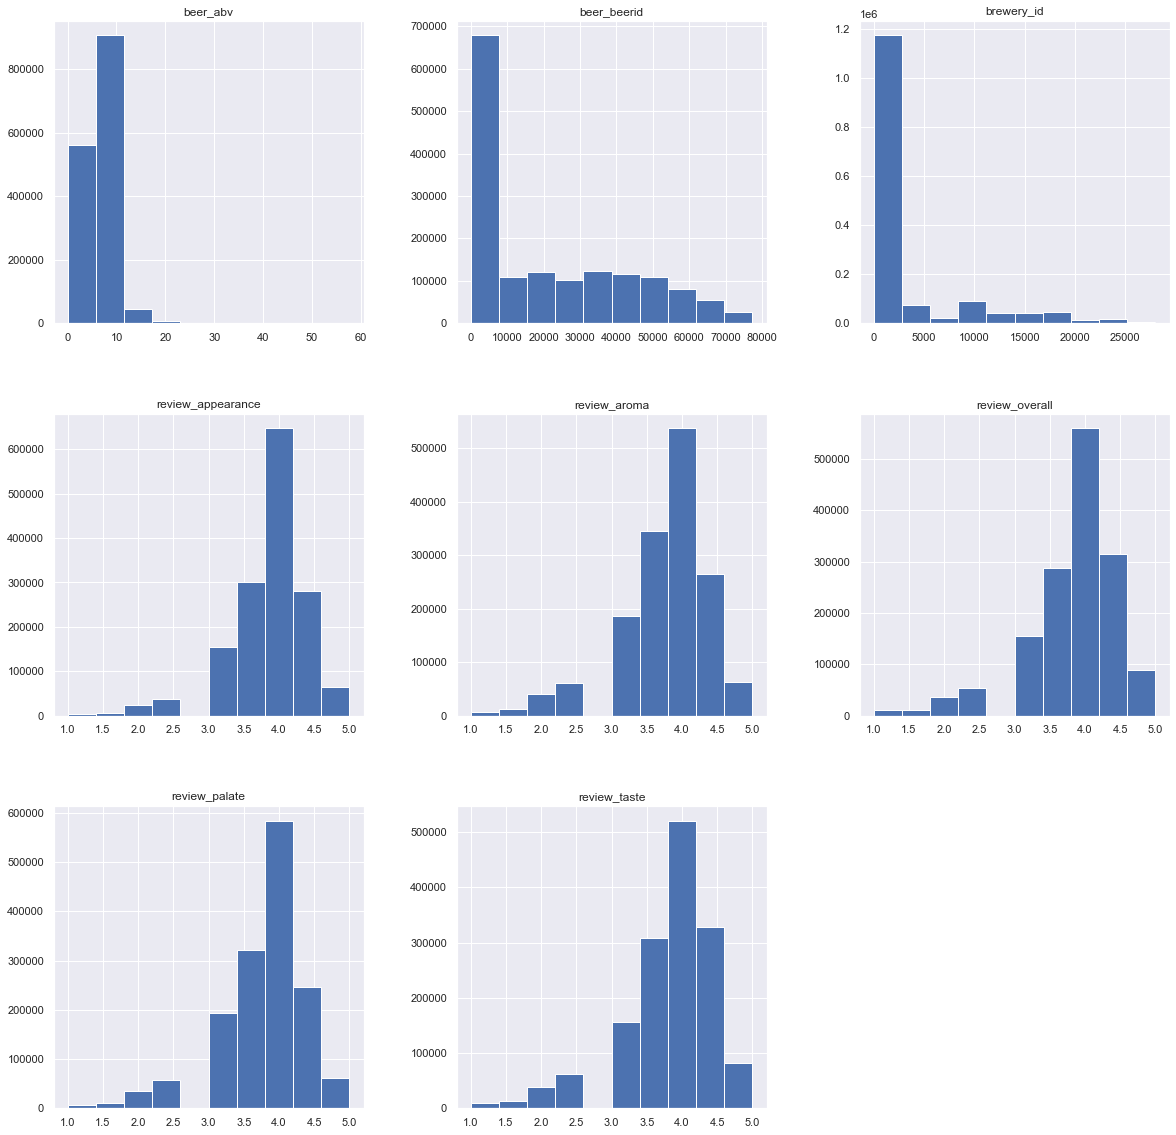

In [15]:
# inspect distribution of dataframe numeric columns
beer_df.hist(figsize = (20,20));


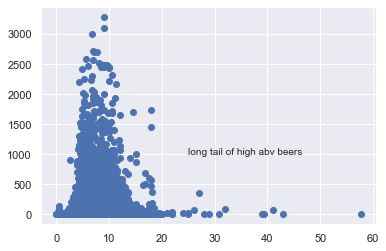

In [16]:
# inspect abv value skewness using a scatterplot
abv_check = beer_df.groupby(["beer_abv", "beer_name"]).size().reset_index(name="counts")

plt.scatter(abv_check["beer_abv"], abv_check["counts"])
plt.annotate("long tail of high abv beers",(25,1000));
plt.show()


In [17]:
# slice dataframe to list beers with values >=20% abv
new_abv_check = abv_check.loc[abv_check["beer_abv"] >= 20].sort_values(
    "beer_abv", ascending = False)
new_abv_check


,beer_abv,beer_name,counts
47368,57.70,Schorschbräu Schorschbock 57%,1
47367,43.00,Schorschbräu Schorschbock 43%,2
47366,41.00,Sink The Bismarck!,76
47365,39.44,Schorschbräu Schorschbock 40%,3
47364,39.00,Black Damnation VI - Messy,7
47363,32.00,Tactical Nuclear Penguin,88
47362,30.86,Schorschbräu Schorschbock 31%,1
47361,29.00,Dave,16
47360,28.00,Ghost Deer,3
47359,27.00,Samuel Adams Utopias,355


A validation of the abv for each individual beer (20 in total) confirmed that **beer_abv** values are correct and should remain in the dataset.

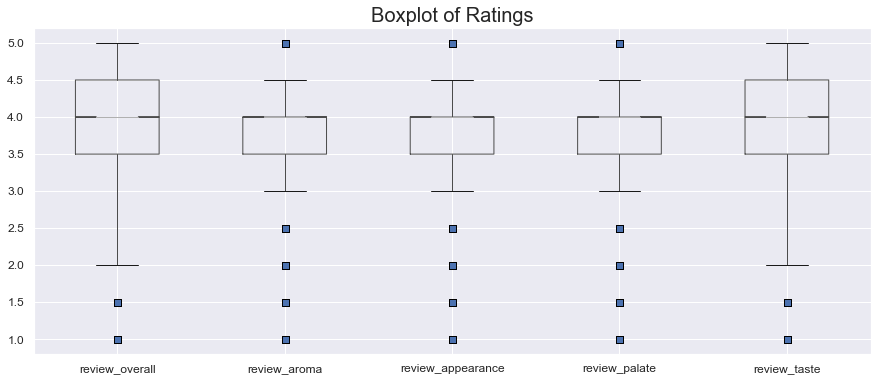

In [18]:
# visualise check of review scores to identify outliers
beer_df.boxplot(column=["review_overall","review_aroma", "review_appearance","review_palate", "review_taste"],
                figsize = (15,6), return_type="axes", notch = True, 
                flierprops=dict(marker='s', markersize = 7, markerfacecolor="b"));

# add title and ticks
plt.title("Boxplot of Ratings", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);


Interestingly, there are 2 distinct groups within the 5 ratings features, which was not immediately evident from the initial histograms.  Also of note is that the proximity of the mean to the median in the group of **review_aroma**, **review_appearance** and **review_palate** is so small that there is no _'notching'_ at the median points in the plot.  This shows how heavily skewed the data is to the upper limit of the ratings, with the absence of the 75% quartile.

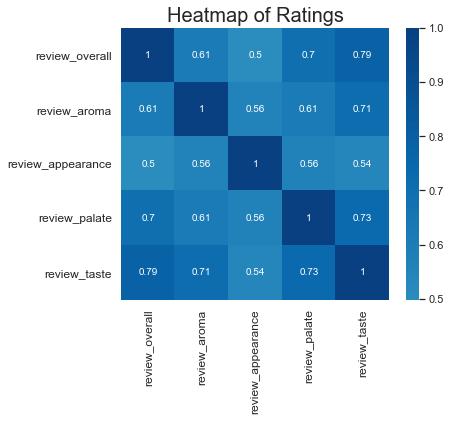

In [19]:
# resize dataframe to analyse ratings
columns = ["beer_style","review_overall","review_aroma","review_appearance","review_palate","review_taste"]
reviews_df = beer_df.loc[:,columns]
#reviews_df = reviews_df.set_index("beer_style")

# plot heatmap to show correlations between the ratings features
plt.figure(figsize=(6,5))
sns.heatmap(reviews_df.corr(), xticklabels=reviews_df.corr().columns, 
            yticklabels=reviews_df.corr().columns, cmap="GnBu", center=0, annot=True)

# add title and ticks
plt.title("Heatmap of Ratings", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [25]:
review_counts = reviews_df.groupby(["beer_style"]).mean()
review_counts

,review_overall,review_aroma,review_appearance,review_palate,review_taste
beer_style,,,,,
Altbier,3.831625,3.635060,3.815625,3.720598,3.756476
American Adjunct Lager,3.010392,2.478646,2.785717,2.736639,2.686335
American Amber / Red Ale,3.803103,3.653259,3.829343,3.677570,3.721220
American Amber / Red Lager,3.577428,3.220028,3.533225,3.362802,3.386036
American Barleywine,3.898904,4.022233,4.040241,3.999924,4.046161
...,...,...,...,...,...
Vienna Lager,3.775978,3.441805,3.707103,3.570914,3.616211
Weizenbock,4.011188,4.049508,4.013296,3.993784,4.081505
Wheatwine,3.819483,3.976793,3.907865,3.946637,3.984575


<Figure size 720x576 with 0 Axes>

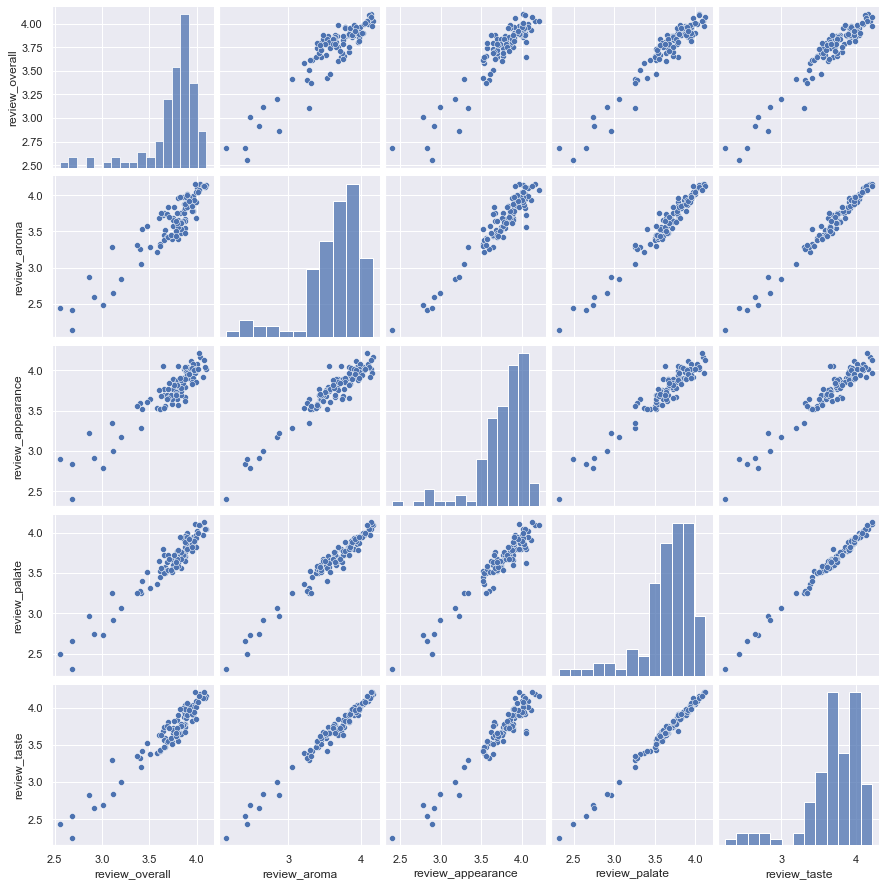

In [30]:
# Plot
plt.figure(figsize=(10,8));
sns.pairplot(review_counts, kind="scatter");
plt.show();


In [ ]:
# check for large number of same reviewers ie reviewer bias
total_reviews = beer_df["review_profilename"].count()
reviewers = beer_df.groupby("review_profilename").size().reset_index(name="counts")
reviewers = reviewers.sort_values(by = "counts", ascending = False)

weighting = round(reviewers["counts"]/total_reviews * 100,2)
weighted_reviewers = pd.concat([reviewers, weighting], axis = 1)
weighted_reviewers.columns = ["review_profilename","ratings","% total"]
weighted_reviewers.head(15)


Now let's look at the categorical values

In [ ]:
beer_df.describe(include=[object])

In [ ]:
# save to csv file for import
beer_data = beer_df.to_csv("data/beer.gz", header = True, compression="gzip", index = False)
